In [1]:
#Import libraries
import pandas as pd
import numpy as np
import math
import os
import glob
import random
import datetime
import shapefile
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify


# Append multiple files and sample at 1%. Stacks datasets on top of one another by month

In [3]:
#target folder and files in that folder
os.chdir(r'C:\Users\stevedc\Documents\DataMining\YellowTaxiTripData')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]


In [6]:
# 1% RESOLUTION FILE
#define datatypes, saves memory and hassle later on.
dtypes = {'VendorID':float, 'passenger_count':float,'trip_distance':float,'RatecodeID':object,'store_and_fwd_flag':object,'PULocationID':int,'DOLocationID':int,'payment_type':object,'fare_amount':float,'extra':float,'mta_tax':float,'tip_amount':float,'tolls_amount':float,'improvement_surcharge':float,'total_amount':float,'congestion_surcharge':float}

#combine all files in the list
dataResolution = 0.01 # defines the fraction of rows to keep
combined_csv = pd.concat([pd.read_csv(f, dtype=dtypes, na_values=None, skiprows=lambda i: i>0 and random.random() > dataResolution, low_memory=False) for f in all_filenames]) # append files, sampling each file before appending according to data resolution

#replace values and convert type
combined_csv.replace('NA', None)
combined_csv[['RatecodeID', 'payment_type']] = combined_csv[['RatecodeID', 'payment_type']].astype(float) # Convert vals to int after replacing NA values



Sampled RowCount =  1011711


(array([-600., -400., -200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 9 Text major ticklabel objects>)

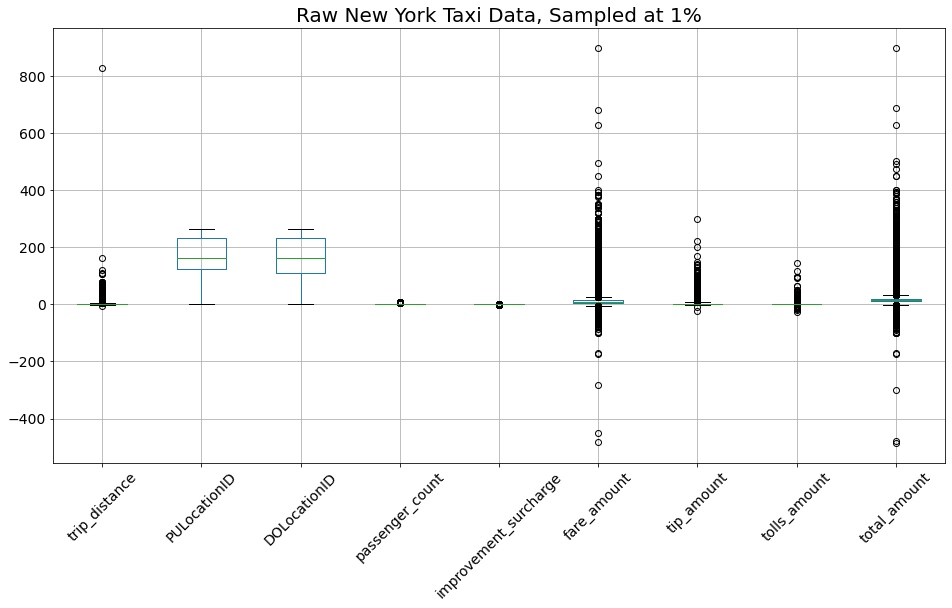

In [16]:
#import other lookup files to merge with main dataset
zones = r'C:\Users\stevedc\Documents\DataMining\taxi+_zone_lookup.csv'
rates = r'C:\Users\stevedc\Documents\DataMining\NYTRateCodes.csv'
payments = r'C:\Users\stevedc\Documents\DataMining\NYTPaymentType.csv'

#create fomrat to parse dates and times into seperate columns
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

print("Sampled RowCount = ", len(combined_csv))

#parse datetime columns
combined_csv['tpep_pickup_datetime'] = pd.to_datetime(combined_csv['tpep_pickup_datetime'])
combined_csv['tpep_dropoff_datetime'] = pd.to_datetime(combined_csv['tpep_dropoff_datetime'])
combined_csv['year'] = combined_csv['tpep_pickup_datetime'].dt.year
combined_csv['month'] = combined_csv['tpep_pickup_datetime'].dt.month
combined_csv['day'] = combined_csv['tpep_pickup_datetime'].dt.day
combined_csv['hour'] = combined_csv['tpep_pickup_datetime'].dt.hour
combined_csv['date'] = combined_csv['tpep_pickup_datetime'].dt.date
combined_csv.round(3)

# Read taxi zones to merge with ty taxi data
df_zones = pd.read_csv(zones, delimiter=',')
df_rates = pd.read_csv(rates, delimiter=',')
df_payments = pd.read_csv(payments, delimiter=',')
#df_zones.sample(5)

# merge pickup and dropoff zones with taxi data using LocationID in zones file to match wth PU/DO LocationID in nytaxi file
df_addPUZones = pd.merge(combined_csv, df_zones, left_on=['PULocationID'], right_on=['LocationID']).drop(['store_and_fwd_flag', 'LocationID'], axis=1)
df_addPUZones.rename(columns={'Borough':'PUBorough', 'Zone':'PUZone', 'service_zone':'PUservice_zone'}, inplace=True) # rename can be combined with merge
df_addDOZones = pd.merge(df_addPUZones, df_zones, left_on=['DOLocationID'], right_on=['LocationID']).drop(['LocationID'], axis=1)
df_addDOZones.rename(columns={'Borough':'DOBorough', 'Zone':'DOZone', 'service_zone':'DOservice_zone'}, inplace=True)
df_addRates = pd.merge(df_addDOZones, df_rates, on=['RatecodeID']).drop(['RatecodeID'], axis=1)
df_nytAll = pd.merge(df_addRates, df_payments, on=['payment_type']).drop(['payment_type'], axis=1)

#df_nytAll.hist(bins=50, figsize=(20,14));
df_nytAll.loc[:, ['trip_distance', 'PULocationID', 'DOLocationID', 'passenger_count', 'improvement_surcharge', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']].boxplot(fontsize=None, rot=0, return_type='both', figsize=(16,8), showfliers=True);
plt.title('Raw New York Taxi Data, Sampled at 1%', fontdict={'fontsize': 20})
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

Cleaned RowCount =  997966


,tax_amount,tip_amount
covid,,
False,193587.13,164021.49
True,4468.23,3258.19


Tax Pre and Post Covid =  None


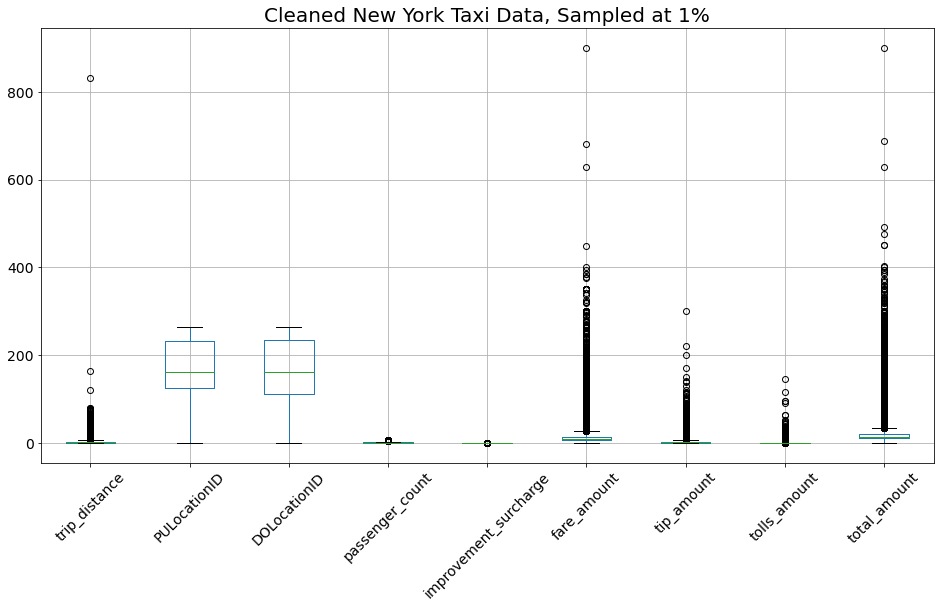

In [25]:
#clean outliers and show refined boxplot, remove refunds, extremes, and negative values
df_nytAll = df_nytAll.loc[(df_nytAll['trip_distance'] >= 0) & (df_nytAll['trip_distance'] < 1000)]
df_nytAll = df_nytAll.loc[(df_nytAll['fare_amount'] > 0) & (df_nytAll['fare_amount'] <= 1500)]
df_nytAll = df_nytAll.loc[(df_nytAll['total_amount'] > 0)]
df_nytAll = df_nytAll.loc[(df_nytAll['PaymentName'] != 'Dispute') & (df_nytAll['PaymentName'] != 'No Charge')]

# clean junk dates, seeing some dates in the early 2000s and in the future which don't make sense
df_nytAll = df_nytAll.loc[df_nytAll['date'] >= pd.to_datetime('2019-01-01')]
df_nytAll = df_nytAll.loc[df_nytAll['date'] <= pd.to_datetime('2020-07-01')]

#add covid boolean column, date where steep dropoff in rides occurs
covidDate = '2020-03-13'

#add route name as combination of from:to locations
df_nytAll['covid'] = np.where(df_nytAll['date']<pd.to_datetime(covidDate),False,True)
df_nytAll['from:to'] = df_nytAll['PUZone'] + ':' + df_nytAll['DOZone']

#add other derived columns
df_nytAll['tax_amount'] = df_nytAll['total_amount'] - (df_nytAll['tip_amount'] + df_nytAll['fare_amount'] + df_nytAll['extra'])

df_nytAll.loc[:, ['trip_distance', 'PULocationID', 'DOLocationID', 'passenger_count', 'improvement_surcharge', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']].boxplot(fontsize=None, rot=0, return_type='both', figsize=(16,8), showfliers=True);
plt.title('Cleaned New York Taxi Data, Sampled at 1%', fontdict={'fontsize': 20})
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

print("Cleaned RowCount = ", len(df_nytAll))
df_nytTax_byCovid = df_nytAll.loc[(df_nytAll['month'] == 4)]
df_nytTax_byCovid = df_nytTax_byCovid.groupby('covid').agg({'tax_amount':'sum','tip_amount':'sum'}) 
print("Tax Pre and Post Covid = ", display(df_nytTax_byCovid))

In [ ]:
#expor to csv
outputFile = r'C:\Users\stevedc\Documents\DataMining\Output Files\nytAll_1pcnt.csv'
df_nytAll.to_csv(outputFile, index=False)



In [13]:
df_nytAll.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int32
DOLocationID                      int32
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
year                              int64
month                             int64
day                               int64
hour                              int64
date                             object
PUBorough                        object
PUZone                           object
PUservice_zone                   object
DOBorough                        object
DOZone                           object
